# CAP 6615 Neural Networks Programming Assignment 4 – CNN && RNN

### Keyuan Lu, Wenxuan Bao, Yiming Xu, Yufan Chen, Yue Bai

In [1]:
import numpy as np
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn as nn

# for evaluating the model
from sklearn.metrics import accuracy_score


from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import shutil
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean

import torchvision
from torchvision import transforms
import torch.utils.data as data
# for creating validation set
from sklearn.model_selection import train_test_split

from skimage import color

## Step 1 - Design and build a dataset for CNN && RNN model

### Select S&P500 Dataset and Schiller P/E ratio. Make an overlay of the Schiller P/E from 1 Jan 1960 to 31 Dec 2020, onto the S&P500 for the same period.

In [2]:
# Read s&p500 price data and schiller pe data.
# Note that 'HistoricalPrices.csv' only includes data after 1978
# Therefore, we use two datasets for s&p500 price ('HistoricalPrices.csv' and 'HistoricalPrices_old.csv' ), 
# and will combine them later
price_new=pd.read_csv('HistoricalPrices.csv')
price_old=pd.read_csv('HistoricalPrices_old.csv')
pe=pd.read_csv('ie_data_PE_full.csv')

In [3]:
# Note that the P/E ratio is monthly data 
pe=pe.rename({'Date':'Date_PE'},axis=1)
pe

,Date_PE,PE_CAPE
0,1960.01,18.338285
1,1960.02,17.545275
2,1960.03,17.286021
3,1960.04,17.429767
4,1960.05,17.256171
...,...,...
727,2020.08,31.152309
728,2020.09,30.833593
729,2020.10,31.277783
730,2020.11,32.471647


In [4]:
# remove redundant variables
price_old = price_old.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_old['Date'] = pd.to_datetime(price_old['Date'])
price_old = price_old.loc[ (price_old['Date'] < '1978-01-03') &  (price_old['Date']  >= '1960-01-01' )]
price_old

,Date,Open,High,Low,Close
2511,1960-01-04,59.910000,59.910000,59.910000,59.910000
2512,1960-01-05,60.389999,60.389999,60.389999,60.389999
2513,1960-01-06,60.130001,60.130001,60.130001,60.130001
2514,1960-01-07,59.689999,59.689999,59.689999,59.689999
2515,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
7016,1977-12-23,93.800003,94.989998,93.750000,94.690002
7017,1977-12-27,94.690002,95.209999,94.089996,94.690002
7018,1977-12-28,94.690002,95.199997,93.989998,94.750000
7019,1977-12-29,94.750000,95.430000,94.099998,94.940002


In [5]:
price_new['Date'] = pd.to_datetime(price_new['Date'])
#reverse the dataset
price_new = price_new.iloc[::-1].reset_index(drop = True)
#reset the column names
price_new. columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_new

,Date,Open,High,Low,Close
0,1978-01-03,93.82,95.15,93.49,93.82
1,1978-01-04,93.52,94.10,93.16,93.52
2,1978-01-05,92.74,94.53,92.51,92.74
3,1978-01-06,91.62,92.66,91.05,91.62
4,1978-01-09,90.64,91.52,90.01,90.64
...,...,...,...,...,...
10839,2020-12-24,3694.03,3703.82,3689.32,3703.06
10840,2020-12-28,3723.03,3740.51,3723.03,3735.36
10841,2020-12-29,3750.01,3756.12,3723.31,3727.04
10842,2020-12-30,3736.19,3744.63,3730.21,3732.04


In [6]:
# combine two s&p500 datasets
# now the dataset includes all the s&p 500 price data from 1 Jan 1960 to 31 Dec 2020  
frames = [price_old, price_new]
price = pd.concat(frames).reset_index(drop = True)
price

,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000


In [7]:
price['Date_PE']=0.0
for i in range(price.shape[0]):
    month = price['Date'][i].month
    year = price['Date'][i].year
    price.loc[i, 'Date_PE']=year+month*0.01
# merge sp500 data with the Schiller P/E ratio based on Date.
data_full = pd.merge(price, pe, how='left', on='Date_PE')
data_full = data_full.drop(['Date_PE' ], 1)

In [8]:
# save the merged dataset
data_full.to_csv('Price_PE.csv')

In [9]:
data_full

,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.338285
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.338285
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.338285
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.338285
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,33.769789
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,33.769789
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,33.769789
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,33.769789


In [10]:
data_full['PE_CAPE']

0        18.338285
1        18.338285
2        18.338285
3        18.338285
4        18.338285
           ...    
15349    33.769789
15350    33.769789
15351    33.769789
15352    33.769789
15353    33.769789
Name: PE_CAPE, Length: 15354, dtype: float64

In [11]:
data_full['PE_CAPE'].values

array([18.33828499, 18.33828499, 18.33828499, ..., 33.76978942,
       33.76978942, 33.76978942])

### Note that the schiller pe ratio is monthly data while the s&p 500 price is daily data. Here we modify the montly schiller pe ratio data to daily data before computing the correlaton.

In [12]:
#modify the monthly schiller pe ratio to daily one
PE_monthly = data_full['PE_CAPE'].values
PE_daily = PE_monthly.copy()
price_tmp = data_full['Close'][0]
for i in range(1, len(PE_monthly)):
    if PE_monthly[i] == PE_monthly[i-1]:
        pe = PE_monthly[i]/price_tmp*data_full['Close'][i]
        PE_daily[i] = pe
        
    else:
        #new month
        price_tmp = data_full['Close'][i]
        PE_daily[i] = PE_monthly[i]
data_full['PE_CAPE'] = PE_daily        

In [13]:
data_full

,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.485211
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.405627
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.270943
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.212785
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,34.144236
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,34.442059
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,34.365344
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,34.411447


### Make an overlay of the Schiller P/E onto the S&P500 for the same period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


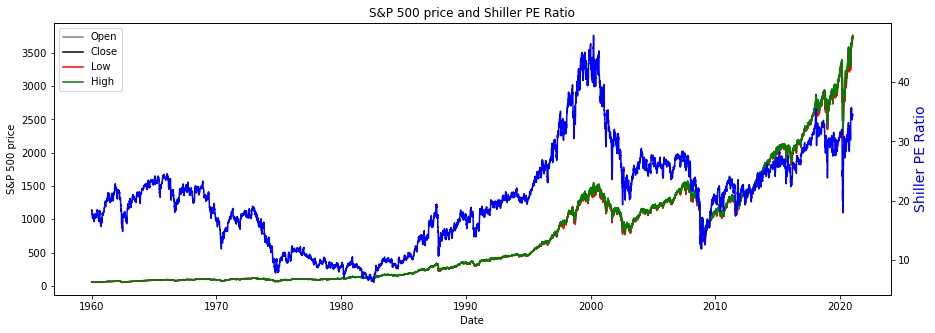

In [14]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, data_full.Open.values, color='grey', label='Open')
plt.plot(data_full.Date, data_full.Close.values, color='black', label='Close')
plt.plot(data_full.Date, data_full.Low.values, color='red', label='Low')
plt.plot(data_full.Date, data_full.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_full.Date, data_full.PE_CAPE.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.savefig('price_pe.eps')
plt.show()


### Here, we are only using ClOSE price and Cyclicily adjusted PE-ratio to train the model

In [15]:
dataset = data_full[ ['Close', 'PE_CAPE']].values
dataset

array([[  59.91      ,   18.33828499],
       [  60.389999  ,   18.48521135],
       [  60.130001  ,   18.40562669],
       ...,
       [3727.04      ,   34.3653445 ],
       [3732.04      ,   34.41144723],
       [3756.07      ,   34.63301695]])

In [16]:
# extract the timestamp data
date_data= data_full[ ['Date']].values

In [17]:
# Feature Scaling: min-max normalization of features
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(dataset)
dataset_scaled

array([[0.00208161, 0.29057405],
       [0.0022112 , 0.29410392],
       [0.002141  , 0.29219192],
       ...,
       [0.99216225, 0.67562076],
       [0.99351219, 0.67672837],
       [1.        , 0.68205154]])

## Step 2 - Develop and test/verify a correlation-based algorithm to correlate when the Schiller P/E ratio is very high (spikes upward significantly) and the S&P500 is also high (peaking or ready to peak)

In [18]:
##Compute correlation score S and add it to the data column
dataset = np.append(dataset, np.zeros([len(dataset),1]),1)

In [19]:
dataset

array([[  59.91      ,   18.33828499,    0.        ],
       [  60.389999  ,   18.48521135,    0.        ],
       [  60.130001  ,   18.40562669,    0.        ],
       ...,
       [3727.04      ,   34.3653445 ,    0.        ],
       [3732.04      ,   34.41144723,    0.        ],
       [3756.07      ,   34.63301695,    0.        ]])

In [20]:
#calcualte the pearson correlation for 180 trading days (same as the window size we use for the testing)
nsample = 180
for i in range(nsample-1 ,len(dataset)):
    # Pearson's r
    x = dataset[(i-nsample+1):(i+1), 0]
    y = dataset[(i-nsample+1):(i+1), 1]
    r = np.corrcoef(x, y)
    dataset[i][2] = r[0,1] 
dataset

array([[5.99100000e+01, 1.83382850e+01, 0.00000000e+00],
       [6.03899990e+01, 1.84852114e+01, 0.00000000e+00],
       [6.01300010e+01, 1.84056267e+01, 0.00000000e+00],
       ...,
       [3.72704000e+03, 3.43653445e+01, 8.56769470e-01],
       [3.73204000e+03, 3.44114472e+01, 8.60287868e-01],
       [3.75607000e+03, 3.46330170e+01, 8.64293744e-01]])

Text(0, 0.5, 'Pearson Correlation')

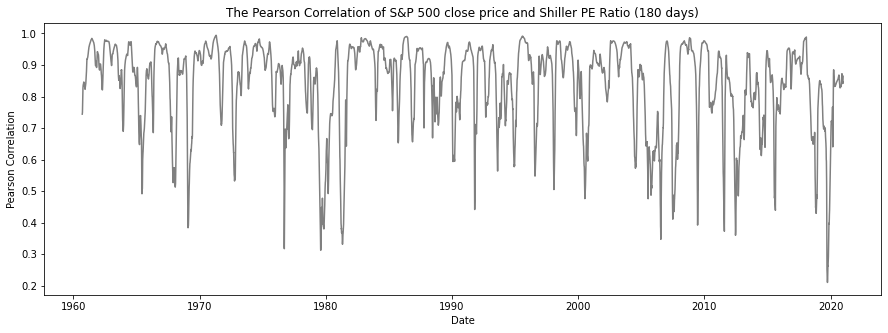

In [21]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date.loc[~data_full.Date.index.isin(list(range(nsample-1))) ],
         dataset[(nsample-1):, 2], color='grey', label='Close')
plt.title('The Pearson Correlation of S&P 500 close price and Shiller PE Ratio (180 days)')
plt.xlabel('Date')
plt.ylabel('Pearson Correlation')
# plt.legend(loc='best')

### We buy and sell the s&p 500 index if the correlation in that window interval is greater than 0.95. We buy at the local minia in that window interval and sell it at the end point in that interval

In [22]:
# assuming you start with $1 million.
money = 1
money_full = []
trade_full = []
# if you haven't sell the stock, you cannot buy the new stock
lastselltime = 0
for i in range(nsample-1, dataset.shape[0]):
    corr_temp = dataset[i,2]
    price_temp = dataset[(i-nsample+1):(i+1), 0]
    if corr_temp > 0.95 and (i-lastselltime > nsample):
        # sell at this point
        # buy at the local minia in this window interval (nsample interval)
        buy_price = min(price_temp)
        # in case of the overflow
        if buy_price > 0:           
            sell_price = price_temp[len(price_temp)-1]
            money = sell_price/buy_price*money
            lastselltime = i
            print(buy_price)
            print(sell_price)
            print(money)
            print(i)  
            money_full.append(money)
            trade_full.append(i)
            

52.200001
64.699997
1.2394635203167907
307
55.5
57.57
1.285692159723201
609
53.490002000000004
65.610001
1.577009922062283
806
69.610001
81.150002
1.8384478737383458
1093
83.629997
86.480003
1.901099884485656
1627
73.199997
90.089996
2.339755300658185
1813
77.849998
77.849998
2.339755300658185
2579
69.290001
94.889999
3.204205151327676
2760
90.160004
110.18
3.915697736363048
3066
102.730003
104.440002
3.980876739750044
3364
90.660004
94.33000200000001
4.142026188553611
3563
62.279999
67.650002
4.499166416809098
3744
87.56
87.64
4.503277121621166
4546
98.22
131.92
6.048384421546164
5219
112.77
123.29
6.6126214004826345
5483
107.2
107.72
6.644697549067065
5664
102.42
158.75
10.299216324100728
5845
154.29
156.69
10.459421905653919
6082
180.66
216.24
12.519347906999908
6558
229.91
296.13
16.125242467486768
6843
263.82
331.84
20.282770299487563
7424
295.46
390.45
26.803654178010287
7868
370.65
408.26
29.523431417009256
8081
402.66
456.33
33.458569161386364
8348
445.45
513.55
38.573685470490

Text(0, 0.5, 'Money (millions)')

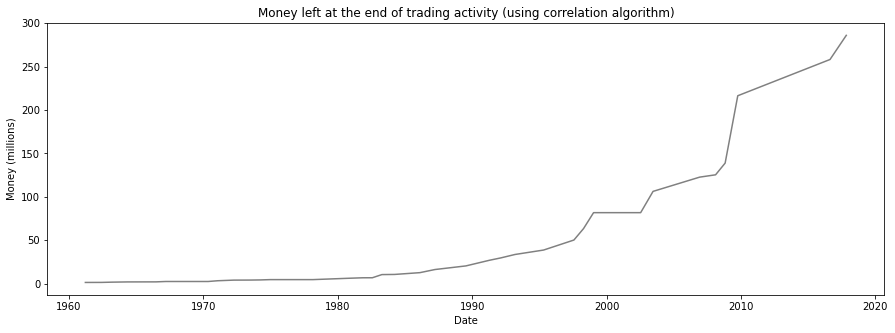

In [23]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date.loc[trade_full],
         money_full, color='grey', label='Close')
plt.title('Money left at the end of trading activity (using correlation algorithm)')
plt.xlabel('Date')
plt.ylabel('Money (millions)')

In [24]:
money

285.90847476329105

In [25]:
##Compute correlation score S and add it to the data column
dataset_scaled = np.append(dataset_scaled, np.zeros([len(dataset),1]),1)
#calcualte the pearson correlation for 180 trading days (same as the window size we use for the testing)
nsample = 180
for i in range(nsample-1 ,len(dataset_scaled)):
    # Pearson's r
    x = dataset_scaled[(i-nsample+1):(i+1), 0]
    y = dataset_scaled[(i-nsample+1):(i+1), 1]
    r = np.corrcoef(x, y)
    dataset_scaled[i][2] = r[0,1] 
dataset_scaled

array([[0.00208161, 0.29057405, 0.        ],
       [0.0022112 , 0.29410392, 0.        ],
       [0.002141  , 0.29219192, 0.        ],
       ...,
       [0.99216225, 0.67562076, 0.85676947],
       [0.99351219, 0.67672837, 0.86028787],
       [1.        , 0.68205154, 0.86429374]])

In [26]:
dataset.shape

(15354, 3)

In [27]:
dataset_scaled.shape

(15354, 3)

### To find some representative figures which include the A-B-C-D-wave patterns in the S&P500 data, we use the data where the correlation coefficient of S&P500 and Schiller P/E ratio is larger than 0.95.   We also add a shifting x-window, by shifting every plot nsample//3 days to get more diverse plots. Besides, we add some constraint conditions that the end price is the highest point and the S&P500 price drop after that day.

In [28]:
sellSignalIndex = []
prev = 0
for x in range(nsample-1, len(dataset_scaled)):
    if dataset_scaled[x][2] > 0.95 and x >= prev+nsample//3 and \
    dataset_scaled[x][0] == max(dataset_scaled[(x-nsample+1):(x+1), 0]) and \
    dataset_scaled[x][0] > dataset_scaled[x+1][0]:
        sellSignalIndex.append(x)
        prev = x

In [29]:
#Now, we have a candidate selling signal list
len(sellSignalIndex)

32

In [30]:
# function to plot the sp500 price data and save the plot 
def drawPlotAndSave(data,index,folder):
    closedpriceInPrevDays = []
    xaxis = np.arange(0, nsample)
    for x in reversed(range(0, nsample)):
        closedpriceInPrevDays.append(data[index-x][0])        
    # plotting
    name = "day%i" %index
    plt.axis('off')
    plt.plot(closedpriceInPrevDays, color ="black") 
    name = name + '.png'
    figure = plt.gcf()
    figure.set_size_inches(8, 8)
    plt.savefig(folder + name, bbox_inches='tight', pad_inches=0, dpi = 100)
    plt.clf()    

In [31]:
#Create the CandaidateTrain folder manually, then run this to create all possible selling signals
folder = 'CandidateTrainSell/'
if os.path.exists(folder ):
    shutil.rmtree(folder )
os.makedirs(folder )

for x in sellSignalIndex:
    drawPlotAndSave(dataset_scaled,x,folder)

<Figure size 576x576 with 0 Axes>

### To find some representative figures which does not include the A-B-C-D-wave patterns in the S&P500 data, we use the data where the correlation coefficient of S&P500 and Schiller P/E ratio is smaller than 0.5.   We also add a shifting x-window, by shifting every plot nsample//3 days to get more diverse plots. Besides, we add some constraint conditions that the end price isn't the highest point.

In [32]:
# not sell 
holdSignalIndex = []
prev = 0
for x in range(nsample-1,len(dataset_scaled)):
    if dataset_scaled[x][2] < 0.5  and x >= prev+nsample//3 and \
    dataset_scaled[x][0] < max(dataset_scaled[(x-nsample+1):(x+1), 0]):
        holdSignalIndex.append(x)
        prev = x
#Now, we have a candidate not selling signal list
len(holdSignalIndex)

22

In [33]:
#Create the CandaidateTrain folder manually, then run this to create all possible hold signals
folder = 'CandidateTrainHold/'
if os.path.exists(folder ):
    shutil.rmtree(folder )
os.makedirs(folder )

for x in holdSignalIndex:
    drawPlotAndSave(dataset_scaled,x,folder)

<Figure size 576x576 with 0 Axes>

### Manually picking CandidateTrain sample, which almost fitting the required ABCD pattern from assignment for label=1 sample

In [34]:
# loading training images
train_img = []
for img_name in tqdm(sellSignalIndex):
    # defining the image path
    image_path = 'CandidateTrainSell/day' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    
    img_resize = resize(img, (180, 180),
                       anti_aliasing=True)
    # converting the type of pixel to float 32
    img_resize = img_resize.astype('float32')
      
    # appending the image into the list
    train_img.append(img_resize)
train_y = np.repeat(1, len(sellSignalIndex))
for img_name in tqdm(holdSignalIndex):
    # defining the image path
    image_path = 'CandidateTrainHold/day' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    
    img_resize = resize(img, (180, 180),
                       anti_aliasing=True)
    # converting the type of pixel to float 32
    img_resize = img_resize.astype('float32')
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img_resize)
train_y = np.append(train_y, np.repeat(0, len(holdSignalIndex))  )  
    
# converting the list to numpy array
train_x = np.array(train_img)
# defining the target

train_x.shape

100%|██████████| 22/22 [00:00<00:00, 43.46it/s]


(54, 180, 180)

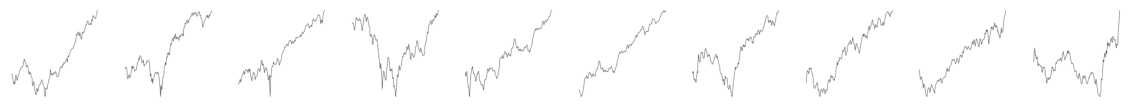

In [35]:
# display first 10 images in the sell dataset
fig, axs = plt.subplots(1, 10 ,figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_x[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.show()

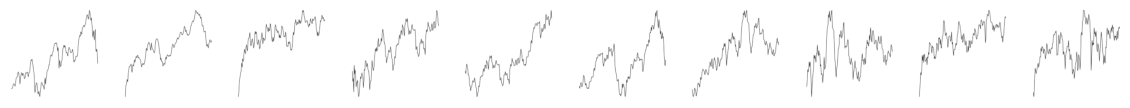

In [36]:
# display first 10 images in the hold dataset
fig, axs = plt.subplots(1, 10 ,figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train_x[len(sellSignalIndex)+ i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.show()

## Step 3 - Design and develop a convolutional neural network (CNN) in Python that will recognize A-B-C-D-wave patterns in the S&P500 data,  using libraries such as PyTorch (and, if necessary, Tensor Flow).  

### Here, we develop CNN and train it with picked Sell and Hold datasets

In [37]:
train_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.20, random_state=0)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((43, 180, 180), (43,)), ((11, 180, 180), (11,)))

In [39]:
val_y

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [40]:
len(val_y)

11

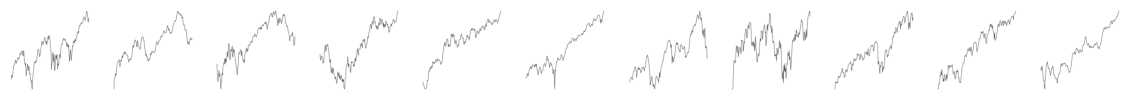

In [41]:
# display the images in the validation dataset
fig, axs = plt.subplots(1, len(val_y) ,figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(val_x[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.show()

In [42]:
train_x.shape[0]

43

In [43]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[2])
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([43, 1, 180, 180]), torch.Size([43]))

In [44]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, val_x.shape[1], val_x.shape[2])
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([11, 1, 180, 180]), torch.Size([11]))

In [45]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(8100, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)      
        x = self.linear_layers(x)
        return x

In [46]:
#set seed for reproducible results
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=8100, out_features=2, bias=True)
  )
)


In [47]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%5 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    # prediction for training set
    with torch.no_grad():
        output = model(train_x)

    softmax = torch.exp(output)
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

    # accuracy on training set
    train_accuracy.append(accuracy_score(train_y, predictions))
    
    # prediction for validation set
    with torch.no_grad():
        output = model(val_x)

    softmax = torch.exp(output)
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

    # accuracy on validation set
    val_accuracy.append(accuracy_score(val_y, predictions))
    
    countHold = sum(np.logical_and(predictions == 0, val_y.numpy() == 0))
    countSell = sum(np.logical_and(predictions == 1, val_y.numpy() == 1))
    
    accuracyhold = countHold/sum(val_y == 0)
    accuracysell = countSell/sum(val_y == 1)
    if epoch%5 == 0:
        print('Epoch: ', epoch+1,  '| Hold/Sell accuracy: %.2f/%.2f' %(accuracyhold, accuracysell))

In [48]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
# defining the number of epochs
n_epochs = 40
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# empty list to store training accuracy
train_accuracy = []
# empty list to store validation accuracy
val_accuracy = []
# training the model

print("Number of train samples: ", len(train_y))
print("Number of test samples: ", len(val_y))
for epoch in range(n_epochs):
    train(epoch)

Number of train samples:  43
Number of test samples:  11
Epoch :  1 	 loss : tensor(0.7969, grad_fn=<NllLossBackward>)
Epoch:  1 | Hold/Sell accuracy: 0.50/1.00
Epoch :  6 	 loss : tensor(0.8312, grad_fn=<NllLossBackward>)
Epoch:  6 | Hold/Sell accuracy: 0.50/1.00
Epoch :  11 	 loss : tensor(1.0819, grad_fn=<NllLossBackward>)
Epoch:  11 | Hold/Sell accuracy: 0.50/1.00
Epoch :  16 	 loss : tensor(1.0197, grad_fn=<NllLossBackward>)
Epoch:  16 | Hold/Sell accuracy: 0.67/1.00
Epoch :  21 	 loss : tensor(0.9836, grad_fn=<NllLossBackward>)
Epoch:  21 | Hold/Sell accuracy: 0.67/1.00
Epoch :  26 	 loss : tensor(0.9645, grad_fn=<NllLossBackward>)
Epoch:  26 | Hold/Sell accuracy: 0.67/1.00
Epoch :  31 	 loss : tensor(0.9553, grad_fn=<NllLossBackward>)
Epoch:  31 | Hold/Sell accuracy: 0.67/1.00
Epoch :  36 	 loss : tensor(0.9526, grad_fn=<NllLossBackward>)
Epoch:  36 | Hold/Sell accuracy: 0.67/1.00


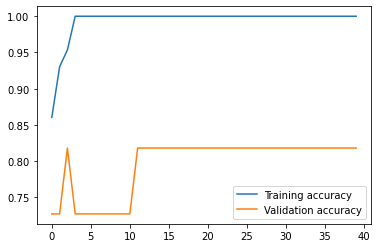

In [49]:
# plotting the training and validation accuracy
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.show()

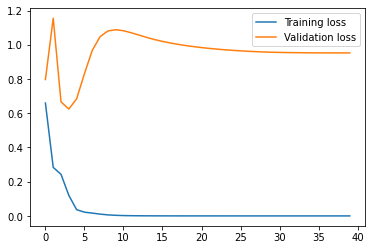

In [50]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [51]:
# prediction for training set
with torch.no_grad():
    output = model(train_x)
    
softmax = torch.exp(output)
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

1.0

In [52]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x)

softmax = torch.exp(output)
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.8181818181818182

In [53]:
torch.argmax(output, dim = 1) 

tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1])

In [54]:
val_y

tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1])

## Step 4 - Train your CNN and RNN on your Training Set (S&P500 data, from Step 1, above) then test to ensure it functions correctly when predicting the next one, two, three, and four trading data (average price or close price - either is o.k.) before you go on to Step 5.  Document your training results

In [55]:
# general settings
# The number of expected features in the input x is 3
input_size = 3
# output_size = 4 as we want to predict the next one, two, three, and four trading data 
output_size = 4
# sequence length is 180
window_size = 180

In [56]:
# number of timepoint and number of feature
n_rows, n_cols = dataset_scaled.shape
(n_rows, n_cols)

(15354, 3)

In [57]:
#Creating a data structure with 180 timesteps and 4 output
X_full = []
y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    y_full.append(dataset_scaled[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

In [58]:
# addtional settings for the RNN
hidden_size = 16
num_layers = 1
num_epochs = 100
learning_rate = 0.001

In [59]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        #just want last time step output 
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

### First, run through CNN on all dataset, and adding CNN output into X_full as the third input

In [60]:
# loading images of the whole dataset
all_img = []
for i in range(X_full.shape[0]):  
    if i%500 == 0:
        print(i)
    x = X_full[i,:, 0]
    # function to plot the sp500 price data    
    plt.axis('off')
    plt.plot(x, color ="black") 
    figure = plt.gcf()
    figure.set_size_inches(8, 8)
    figure.canvas.draw()
       
    width, height = figure.get_size_inches() * figure.get_dpi()
    mplimage = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
    gray_image = color.rgb2gray(mplimage)
    img_resize = resize(gray_image, (180, 180),anti_aliasing=True)
    img_resize = img_resize.astype('float32')
    plt.clf()   
    # appending the image into the list
    all_img.append(img_resize)
    
# converting the list to numpy array
all_x = np.array(all_img)
# defining the target
all_x.shape

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000


(15171, 180, 180)

<Figure size 576x576 with 0 Axes>

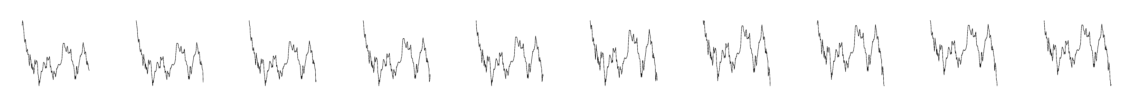

In [61]:
# display first 10 images 
fig, axs = plt.subplots(1, 10 ,figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(all_x[i], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.show()

In [62]:
dataset = data_full[ ['Close', 'PE_CAPE']].values
dataset = np.append(dataset, np.zeros([len(dataset),1]),1)
dataset.shape

(15354, 3)

In [63]:
# converting images into torch format
all_x = all_x.reshape(all_x.shape[0], 1, all_x.shape[1], all_x.shape[2])
all_x = torch.from_numpy(all_x)
all_x.shape

torch.Size([15171, 1, 180, 180])

In [64]:
# predict sell signal for whole dataset
with torch.no_grad():
    output = model(all_x)

softmax = torch.exp(output)
# if prob > 0.5 then sell signal
# otherwise, hold 
prob = softmax.numpy()[:,1]/np.sum(softmax.numpy(), axis = 1) 

In [65]:
for i in range( len(prob)):
    dataset[i+ window_size, 2] = prob[i]

In [66]:
# Feature Scaling: min-max normalization of features
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(dataset)
dataset_scaled

array([[0.00208161, 0.29057405, 0.        ],
       [0.0022112 , 0.29410392, 0.        ],
       [0.002141  , 0.29219192, 0.        ],
       ...,
       [0.99216225, 0.67562076, 0.        ],
       [0.99351219, 0.67672837, 0.        ],
       [1.        , 0.68205154, 0.        ]])

In [67]:
# Creating a data structure with 180 timesteps and 4 output
X_full = []
y_full = []
date_full = []
for i in range(window_size , n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    y_full.append(dataset_scaled[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

In [68]:
X_full.shape

(14991, 180, 3)

### The NYSE and NASDAQ average about 253 trading days a year. We use 20\% for testing, i.e. first 200 days for training, and consecutive 53 datapoints for testing.

### We further split the training dataset to smaller training dataset (80\%) and validation set (20\%) to determine the optimal number of iteration.

In [69]:
X_train = []; y_train = []; date_train = []
X_val = []; y_val = []; date_val = []
X_test = []; y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        y_test.append(y_full[i])
        date_test.append(date_full[i])
    elif (i % 253 < 160):
        X_train.append(X_full[i])
        y_train.append(y_full[i])
        date_train.append(date_full[i])
    else:
        X_val.append(X_full[i])
        y_val.append(y_full[i])
        date_val.append(date_full[i])
X_train, y_train, date_train = np.array(X_train), np.array(y_train), np.array(date_train) 
X_val, y_val, date_val = np.array(X_val), np.array(y_val), np.array(date_val) 
X_test, y_test, date_test = np.array(X_test), np.array(y_test), np.array(date_test)                

In [70]:
X_train.shape

(9504, 180, 3)

In [71]:
X_val.shape

(2360, 180, 3)

In [72]:
X_test.shape

(3127, 180, 3)

In [73]:
out_temp = np.concatenate((y_train[:, 0, [0]], 
                           y_train[:, 0, [0]],
                           y_train[:, 0, [0]]), axis=1)
price_train = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((y_val[:, 0, [0]], 
                           y_val[:, 0, [0]],
                           y_val[:, 0, [0]]), axis=1)
price_val = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((y_test[:, 0, [0]], 
                           y_test[:, 0, [0]],
                           y_test[:, 0, [0]]), axis=1)
price_test = sc.inverse_transform(out_temp)[:, [0]]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


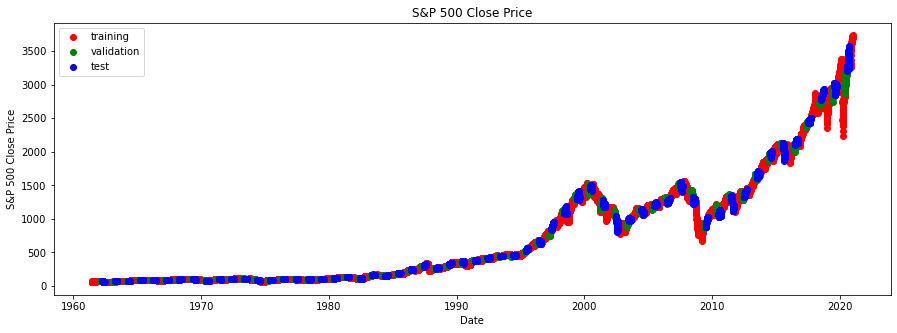

In [74]:
# Visualising training dataset and test dataset
plt.figure(figsize=(15, 5));
plt.plot(date_train, price_train[:,0], color = 'red', label = 'training', marker= 'o', linestyle='None')
plt.plot(date_val, price_val[:,0], color = 'green', label = 'validation', marker= 'o', linestyle='None')
plt.plot(date_test, price_test[:,0], color = 'blue', label = 'test', marker= 'o', linestyle='None')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.savefig('dataset_full.eps')
plt.show()

### Now, we traing the RNN model

In [75]:
#set seed for reproducible results
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
rnn = RNN(input_size, output_size, hidden_size, num_layers)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [76]:
# display the rnn structure
rnn

RNN(
  (rnn): RNN(3, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [77]:
# display the weights (including bias) name and shape
for name, param in rnn.named_parameters():
    print(name)
    print(param.data.shape)

rnn.weight_ih_l0
torch.Size([16, 3])
rnn.weight_hh_l0
torch.Size([16, 16])
rnn.bias_ih_l0
torch.Size([16])
rnn.bias_hh_l0
torch.Size([16])
fc.weight
torch.Size([4, 16])
fc.bias
torch.Size([4])


In [78]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
loss_all_1 = []
loss_all_1_val = []
for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())
    
    # zero the parameter (weight) gradients
    optimiser.zero_grad()

    # Perform forward pass
    output, hidden = rnn(inputs)   
    
    # Compute loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_all_1 += [loss.item()]
       
    # Backward pass
    loss.backward(retain_graph=True)
       
    #loss for validation
    inputs_val = torch.from_numpy(X_val).float()
    labels_val = torch.from_numpy(y_val).float()
    output_val, hidden_val = rnn(inputs_val)
    loss_val = criterion(output_val.reshape(-1), labels_val.view(-1))
    loss_all_1_val += [loss_val.item()]
    
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "MSE: ", loss.item())
    
    # Update parameters
    optimiser.step()                                


Epoch  0 MSE:  0.14543795585632324
Epoch  10 MSE:  0.09185334295034409
Epoch  20 MSE:  0.06024594604969025
Epoch  30 MSE:  0.044391609728336334
Epoch  40 MSE:  0.04009271785616875
Epoch  50 MSE:  0.03812818601727486
Epoch  60 MSE:  0.035607919096946716
Epoch  70 MSE:  0.033101893961429596
Epoch  80 MSE:  0.03008354641497135
Epoch  90 MSE:  0.02622453309595585


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


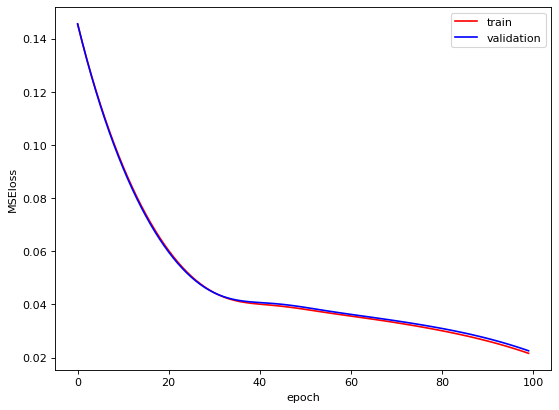

In [79]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(loss_all_1), 'r', label = 'train')
plt.plot(np.array(loss_all_1_val), 'b', label = 'validation')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()
plt.savefig('MSEloss_1.eps')

### From the plot of MSE loss above, we could see that the MSE of training set and validation set are quite similar. The loss for the validation set keep decrease. Therefore, no overfitting issue. However, based on the prediction plot shown below, there is a significant underfitting issue.

In [80]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
out_temp.shape
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
predicted_price

array([[ 801.8783 ],
       [ 803.4143 ],
       [ 801.85846],
       ...,
       [1445.9847 ],
       [1445.2708 ],
       [1446.3629 ]], dtype=float32)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


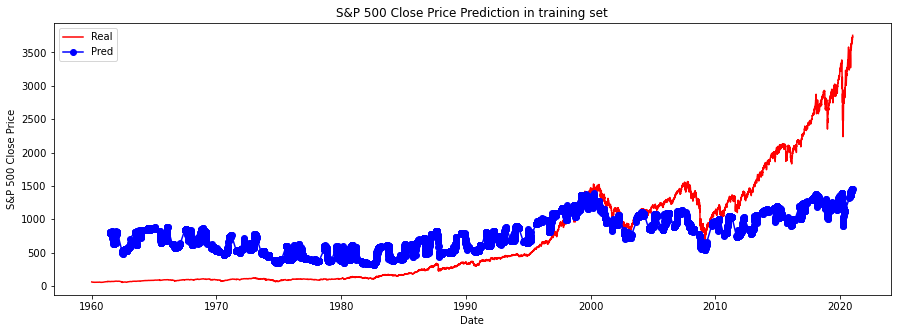

In [81]:
# Visualising the results in training dataset
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.savefig('prediction_1.eps')
plt.show()

### Accuracy will be computed in terms of error defined as prediction_error := |predicted_price - actual_price| / actual_price 

In [82]:
# compute prediction_error := (predicted_price - actual_price) / actual_price 
def prediction_error(target, pred):
    error = abs(pred - target)/target
    return error

In [83]:
out_temp = np.concatenate( (y_train[:, :, 0], y_train[:, :, 0], y_train[:, :, 0]), axis = 1)
target_train = sc.inverse_transform(out_temp)[:, [0]]
error_train_1 = prediction_error(target_train, predicted_price)

In [84]:
# predict next two day
train_inputs = Variable(torch.from_numpy(X_train).float())
output_train, _ = rnn(train_inputs)
out_temp = np.concatenate((output_train.detach().numpy()[:, [1]], 
                           output_train.detach().numpy()[:, [1]], 
                           output_train.detach().numpy()[:, [1]]), axis=1)
predicted_price_train = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_train[:, :, 1], y_train[:, :, 1], y_train[:, :, 1]), axis = 1)
target_train = sc.inverse_transform(out_temp)[:, [0]]
error_train_2 = prediction_error(target_train, predicted_price_train)
predicted_price_train

array([[ 659.94995],
       [ 663.47894],
       [ 661.7002 ],
       ...,
       [1688.9612 ],
       [1688.4801 ],
       [1690.2267 ]], dtype=float32)

In [85]:
# predict next three day
# train_inputs = Variable(torch.from_numpy(X_train).float())
# output_train, _ = rnn(train_inputs)
out_temp = np.concatenate((output_train.detach().numpy()[:, [2]], 
                           output_train.detach().numpy()[:, [2]], 
                           output_train.detach().numpy()[:, [2]]), axis=1)
predicted_price_train = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_train[:, :, 2], y_train[:, :, 2], y_train[:, :, 2]), axis = 1)
target_train = sc.inverse_transform(out_temp)[:, [0]]
error_train_3 = prediction_error(target_train, predicted_price_train)
predicted_price_train

array([[ 744.1481 ],
       [ 739.1808 ],
       [ 743.07104],
       ...,
       [1531.914  ],
       [1532.1221 ],
       [1533.9993 ]], dtype=float32)

In [86]:
# predict next four day
# train_inputs = Variable(torch.from_numpy(X_train).float())
# output_train, _ = rnn(train_inputs)
out_temp = np.concatenate((output_train.detach().numpy()[:, [3]], 
                           output_train.detach().numpy()[:, [3]], 
                           output_train.detach().numpy()[:, [3]]), axis=1)
predicted_price_train = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_train[:, :, 3], y_train[:, :, 3], y_train[:, :, 3]), axis = 1)
target_train = sc.inverse_transform(out_temp)[:, [0]]
error_train_4 = prediction_error(target_train, predicted_price_train)
predicted_price_train

array([[ 685.87787],
       [ 687.90576],
       [ 687.67126],
       ...,
       [2159.5117 ],
       [2159.3867 ],
       [2163.1018 ]], dtype=float32)

### Graph prediction_error as a function of timestamp (e.g., DD/MM/YYYY) for all data in the Training Set. 

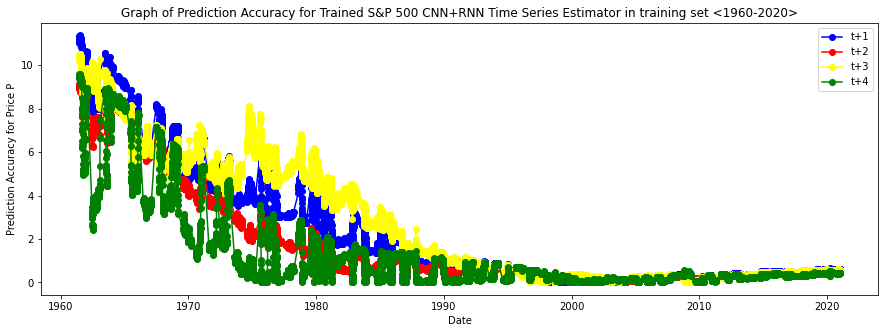

In [87]:
plt.figure(figsize=(15, 5));
plt.plot(date_train, error_train_1, color = 'blue', label = 't+1', marker= 'o')
plt.plot(date_train+ pd.Timedelta('1 day'), error_train_2, color = 'red', label = 't+2', marker= 'o')
plt.plot(date_train+ pd.Timedelta('2 day'), error_train_3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_train+ pd.Timedelta('3 day'), error_train_4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator in training set <1960-2020>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

## Step 5 - Test your CNN and RNN accuracy over Test Data on which you did not train, to determine how well your neural networks generalize -- specifically, in terms of predicting the next one, two, three, and four datapoints in the dataset from 1 Jan 1980 through the present day. 

In [88]:
# predict next one day
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
predicted_price_test

array([[ 620.08636],
       [ 617.73206],
       [ 617.705  ],
       ...,
       [1322.3477 ],
       [1331.5262 ],
       [1323.7781 ]], dtype=float32)

In [89]:
#only display the result after 1980
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]

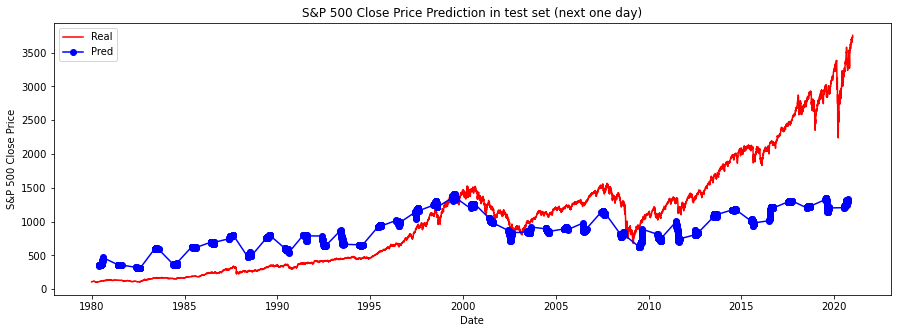

In [90]:
# Visualising the results in test dataset
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date[data_full.Date>myDatetime], dataset[data_full.Date>myDatetime,0], color = 'red', label = 'Real')
plt.plot(date_test_partial,
         predicted_price_test[date_test>myDatetime], color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

In [91]:
out_temp = np.concatenate( (y_test[:, :, 0], y_test[:, :, 0], y_test[:, :, 0]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)

In [92]:
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial_1 = error_test[date_test>myDatetime]

In [93]:
# predict next two day
# test_inputs = Variable(torch.from_numpy(X_test).float())
# output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, 1], y_test[:, :, 1], y_test[:, :, 1]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[ 605.5571 ],
       [ 601.44403],
       [ 599.5343 ],
       ...,
       [1518.3572 ],
       [1517.3257 ],
       [1510.6686 ]], dtype=float32)

In [94]:
error_partial_2 = error_test[date_test>myDatetime]

In [95]:
# predict next three day
# test_inputs = Variable(torch.from_numpy(X_test).float())
# output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, 2], y_test[:, :, 2], y_test[:, :, 2]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[ 597.08496],
       [ 599.72656],
       [ 599.3584 ],
       ...,
       [1452.9904 ],
       [1424.9095 ],
       [1439.8186 ]], dtype=float32)

In [96]:
error_partial_3 = error_test[date_test>myDatetime]

In [97]:
# predict next four day
# test_inputs = Variable(torch.from_numpy(X_test).float())
# output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, 3], y_test[:, :, 3], y_test[:, :, 3]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[ 401.7535 ],
       [ 399.2629 ],
       [ 398.90363],
       ...,
       [1920.2838 ],
       [1900.5863 ],
       [1899.6538 ]], dtype=float32)

In [98]:
error_partial_4 = error_test[date_test>myDatetime]

### Graph prediction_error as a function of timestamp (e.g., DD/MM/YYYY) for all data in the Test Set. 

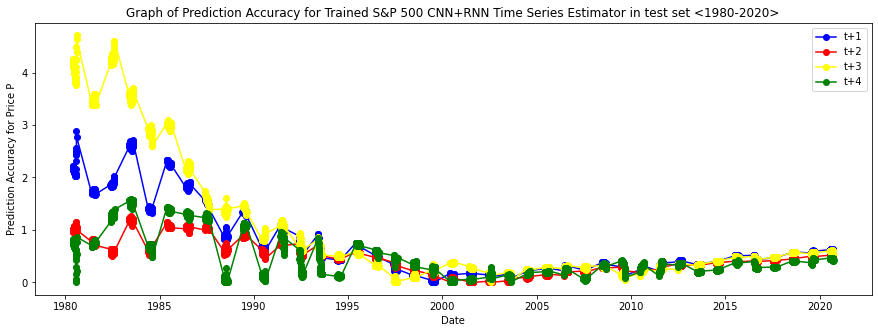

In [99]:
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial_1, color = 'blue', label = 't+1', marker= 'o')
plt.plot(date_test_partial+ pd.Timedelta('1 day'), error_partial_2, color = 'red', label = 't+2', marker= 'o')
plt.plot(date_test_partial+ pd.Timedelta('2 day'), error_partial_3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_test_partial+ pd.Timedelta('3 day'), error_partial_4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator in test set <1980-2020>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

## Step 6 - Optimize your CNN+RNN algorithm's performance to yield maximum achievable accuracy (e.g., minimum predicted_error) over the entire Training Set and Test Set.  

### reconstruct the training set and test set. (No validation set at this time)

In [100]:
# Creating a data structure with 180 timesteps and 4 output
X_full = []
y_full = []
date_full = []
for i in range(window_size , n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    y_full.append(dataset_scaled[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

In [101]:
X_full.shape

(14991, 180, 3)

In [102]:
X_train = []; y_train = []; date_train = []
X_test = []; y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        y_test.append(y_full[i])
        date_test.append(date_full[i])
    else:
        X_train.append(X_full[i])
        y_train.append(y_full[i])
        date_train.append(date_full[i])
X_train, y_train, date_train = np.array(X_train), np.array(y_train), np.array(date_train)          
X_test, y_test, date_test = np.array(X_test), np.array(y_test), np.array(date_test)      

In [103]:
X_train.shape

(11864, 180, 3)

### To overcome the underfitting issue, we increase the number layer from 1 to 2, increase hidden unit size from 8 to 32. In addition, we increase the learning rate from 0.001 to 0.005 to speed up the learning process.

In [104]:
input_size = 3
hidden_size = 32
num_layers = 2
output_size = 4
num_epochs = 100
learning_rate = 0.005
window_size = 180

In [105]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
rnn = RNN(input_size, output_size, hidden_size, num_layers)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [106]:
# display the rnn structure
rnn

RNN(
  (rnn): RNN(3, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [107]:
# display the weights (including bias) name and shape
for name, param in rnn.named_parameters():
    print(name)
    print(param.data.shape)

rnn.weight_ih_l0
torch.Size([32, 3])
rnn.weight_hh_l0
torch.Size([32, 32])
rnn.bias_ih_l0
torch.Size([32])
rnn.bias_hh_l0
torch.Size([32])
rnn.weight_ih_l1
torch.Size([32, 32])
rnn.weight_hh_l1
torch.Size([32, 32])
rnn.bias_ih_l1
torch.Size([32])
rnn.bias_hh_l1
torch.Size([32])
fc.weight
torch.Size([4, 32])
fc.bias
torch.Size([4])


In [108]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden = rnn(inputs) 
    
    loss = criterion(output.reshape(-1), labels.view(-1))
    
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "MSE: ", loss.item())
    optimiser.zero_grad()

    # Backward pass
    loss.backward(retain_graph=True)

    # Update parameters
    optimiser.step()       

Epoch  0 MSE:  0.08102680742740631
Epoch  10 MSE:  0.01162358745932579
Epoch  20 MSE:  0.002097048331052065
Epoch  30 MSE:  0.0011750260600820184
Epoch  40 MSE:  0.0003239162906538695
Epoch  50 MSE:  0.0002961818827316165
Epoch  60 MSE:  0.0001752388197928667
Epoch  70 MSE:  0.00014752091374248266
Epoch  80 MSE:  0.00012648376286961138
Epoch  90 MSE:  0.0001088783610612154


In [109]:
all_inputs = Variable(torch.from_numpy(X_full).float())
output_all, _ = rnn(all_inputs)

In [110]:
#predict next one day (idx = 0)
idx = 0
out_temp = np.concatenate((output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]]), axis=1)
predicted_price_all = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_full[:, :, idx], y_full[:, :, idx], y_full[:, :, idx]), axis = 1)
target_all = sc.inverse_transform(out_temp)[:, [0]]
error_all_1 = prediction_error(target_all, predicted_price_all)
predicted_price_all

array([[  56.175117],
       [  57.31028 ],
       [  57.810265],
       ...,
       [3468.6592  ],
       [3463.2363  ],
       [3463.4568  ]], dtype=float32)

In [111]:
#predict next two day (idx = 1)
idx = 1
out_temp = np.concatenate((output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]]), axis=1)
predicted_price_all = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_full[:, :, idx], y_full[:, :, idx], y_full[:, :, idx]), axis = 1)
target_all = sc.inverse_transform(out_temp)[:, [0]]
error_all_2 = prediction_error(target_all, predicted_price_all)
predicted_price_all

array([[  52.058174],
       [  51.48727 ],
       [  51.59642 ],
       ...,
       [3448.354   ],
       [3443.0623  ],
       [3444.033   ]], dtype=float32)

In [112]:
#predict next three day (idx = 2)
idx = 2
out_temp = np.concatenate((output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]]), axis=1)
predicted_price_all = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_full[:, :, idx], y_full[:, :, idx], y_full[:, :, idx]), axis = 1)
target_all = sc.inverse_transform(out_temp)[:, [0]]
error_all_3 = prediction_error(target_all, predicted_price_all)
predicted_price_all

array([[  58.465446],
       [  58.082375],
       [  59.463333],
       ...,
       [3494.3323  ],
       [3490.005   ],
       [3492.0598  ]], dtype=float32)

In [113]:
#predict next four day (idx = 3)
idx = 3
out_temp = np.concatenate((output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]], 
                           output_all.detach().numpy()[:, [idx]]), axis=1)
predicted_price_all = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_full[:, :, idx], y_full[:, :, idx], y_full[:, :, idx]), axis = 1)
target_all = sc.inverse_transform(out_temp)[:, [0]]
error_all_4 = prediction_error(target_all, predicted_price_all)
predicted_price_all

array([[  42.137897],
       [  43.59883 ],
       [  43.3859  ],
       ...,
       [3365.2773  ],
       [3360.6943  ],
       [3362.6216  ]], dtype=float32)

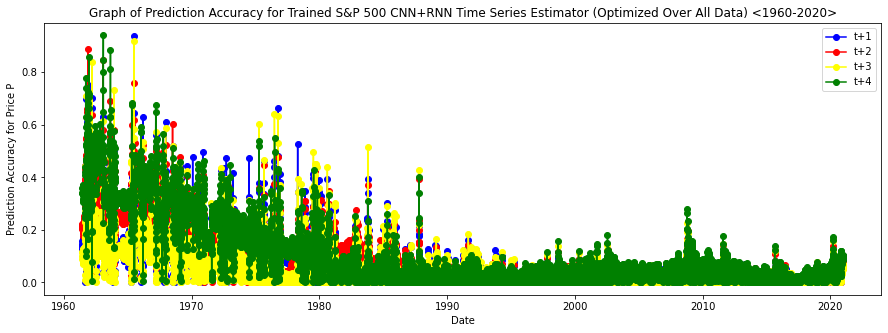

In [114]:
plt.figure(figsize=(15, 5));
plt.plot(date_full, error_all_1, color = 'blue', label = 't+1', marker= 'o')
plt.plot(date_full+ pd.Timedelta('1 day'), error_all_2, color = 'red', label = 't+2', marker= 'o')
plt.plot(date_full+ pd.Timedelta('2 day'), error_all_3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_full+ pd.Timedelta('3 day'), error_all_4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator (Optimized Over All Data) <1960-2020>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

### In order to see each case clearly, we also plot the four cases seperately

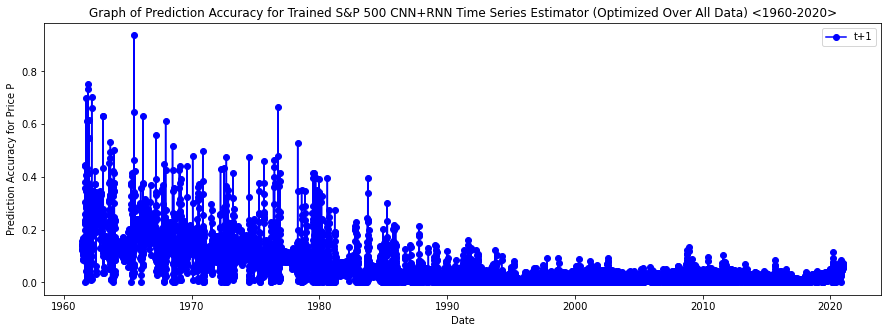

In [115]:
plt.figure(figsize=(15, 5));
plt.plot(date_full, error_all_1, color = 'blue', label = 't+1', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator (Optimized Over All Data) <1960-2020>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

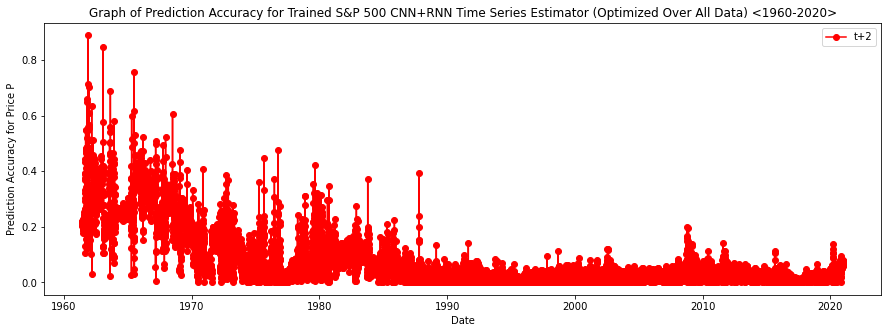

In [116]:
plt.figure(figsize=(15, 5));
plt.plot(date_full+ pd.Timedelta('1 day'), error_all_2, color = 'red', label = 't+2', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator (Optimized Over All Data) <1960-2020>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

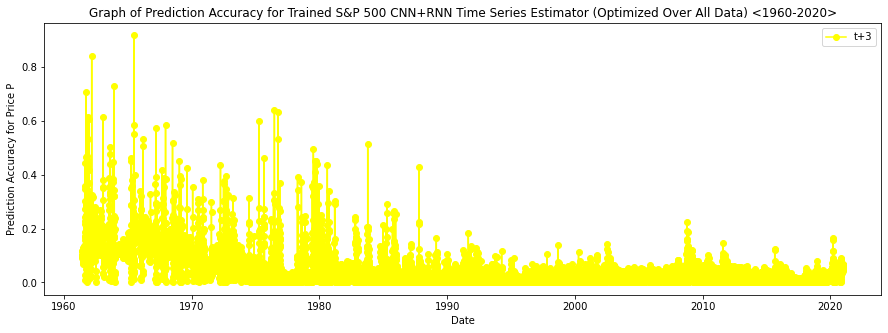

In [117]:
plt.figure(figsize=(15, 5));
plt.plot(date_full+ pd.Timedelta('2 day'), error_all_3, color = 'yellow', label = 't+3', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator (Optimized Over All Data) <1960-2020>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

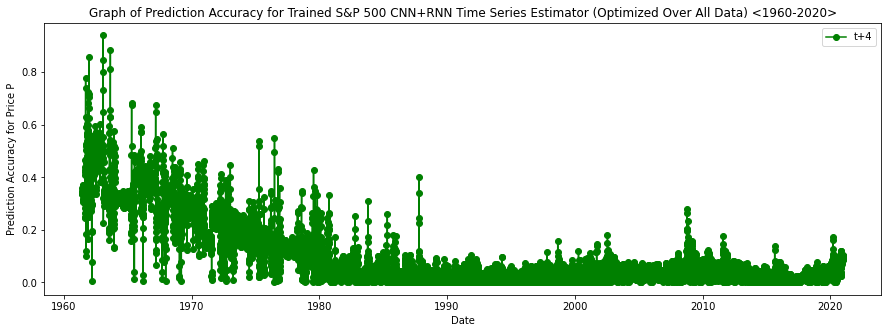

In [118]:
plt.figure(figsize=(15, 5));
plt.plot(date_full+ pd.Timedelta('3 day'), error_all_4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator (Optimized Over All Data) <1960-2020>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

## Step 7 - Enhance your CNN+RNN algorithm's functionality to generate a SELL signal when the S&P500 is about to peak, then use the algorithm you developed in Step 2 of this assignment to check your CNN+RNN algorthm's profitability against.the correlation-based result you computed in Step 2.  

In [119]:
X_full.shape

(14991, 180, 3)

In [120]:
# assuming you start with $1 million.
money = 1
money_full = []
trade_full = []
# if you haven't sell the stock, you cannot buy the new stock,
lastselltime = -nsample
for i in range(1,X_full.shape[0]):
    temp = sc.inverse_transform(X_full[i,:, :])
    prob_temp = temp[:, 2]
    price_temp = temp[:, 0]
    if prob_temp[nsample-1] > 0.95 and (i-lastselltime > nsample):
        # sell at this point
        # buy at the local minia in this window interval
        buy_price = min(price_temp)
        # in case of the overflow
        if buy_price > 0:
            sell_price = price_temp[len(price_temp)-1]
            money = sell_price/buy_price*money
            lastselltime = i
            print(buy_price)
            print(sell_price)
            print(money)
            print(i)   
            money_full.append(money)
            trade_full.append(i)

52.200001
66.66999799999999
1.2772030023524328
1
52.32
66.199997
1.616032777601721
416
64.099998
73.32
1.8484793596055678
597
69.610001
83.360001
2.2136078013445153
778
81.32
88.040001
2.396532624741502
969
81.599998
93.949997
2.759243117933241
1162
73.199997
88.529999
3.3371010994903014
1449
88.239998
94.16999799999999
3.561364585080787
1630
87.720001
102.309998
4.15370724376629
1825
69.290001
90.099998
5.401197993285181
2378
90.160004
108.889999
6.52325219603612
2714
104.739998
120.239998
7.4885988732296775
2895
62.279999
88.099998
10.593217025490588
3476
82.089996
102.849998
13.2721696062121
3705
86.9
104.65
15.983113340507439
4308
92.49
101.82
17.595422211379255
4542
98.22
131.73
23.598503033037964
4848
102.42
133.88
30.847174243928166
5388
134.2
162.16
37.27405197761096
5569
147.82
175.48
44.2487528144444
5934
176.53
182.78
45.8153687159358
6115
186.08
250.84
61.76014127636143
6296
229.91
292.7799999999999
78.64875021918618
6477
256.98
292.69
89.57779866780918
6983
295.45999999999

### In 2020, our asset will be more than fourteen billion using CNN algorithm, which is much larger than using correlation algorithm in step 2.

In [121]:
money 

14375.30310497055

In [122]:
date_full.shape

(14991, 1)

In [123]:
X_full.shape

(14991, 180, 3)

Text(0, 0.5, 'Money (millions)')

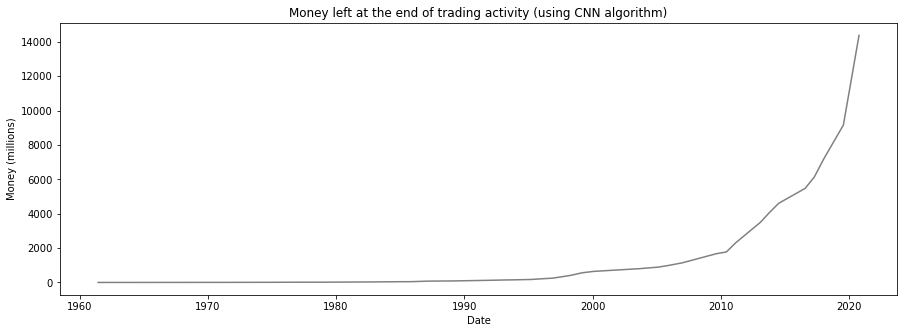

In [124]:
plt.figure(figsize=(15, 5));
plt.plot(date_full[trade_full],
         money_full, color='grey', label='Close')
plt.title('Money left at the end of trading activity (using CNN algorithm)')
plt.xlabel('Date')
plt.ylabel('Money (millions)')

## Step 8 - Determine the Effect of Input Data Perturbations (Price Uncertainty) on your CNN+RNN Algorithm:

### 8a) Using your Optimized CNN+RNN algorithm (from Step 6, above) corrupt your Test Set that you used in Step 5, above:

### Add noise to the S&P 500 price data - NOT to the Schiller P/E data.

### You can scale the noise accordingly within your sampling window shown in FIgure 2.

### Note that any negative values that result from noise corruption of S&P500 price data should be set to some small value greater than zero (you choose what that value is), for physical realism.

In [125]:
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(window_size)), 18)
        dataset_noise[i] = dataset[i] 
        #scale the s accordingly within the sampling window
        s = max(X_test[1, index, 0])*s
        temp = dataset_noise[i, index, 0] + s
        # modify the data if it is negative
        temp[temp < 0] = 0.0000001
        dataset_noise[i, index, 0]  = temp
        
    return dataset_noise   

### 8b) Repeat Tests in Step 6, above, with noise-corrupted Test Set.

In [126]:
#predict next day (idx = 0)
idx = 0
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [127]:
#only display the result after 1980
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_res_all_partial_1 = []
for i in range(len(sd)):
    temp = error_res_all[i].reshape(-1, 1)
    temp = temp[date_test > myDatetime,]
    error_res_all_partial_1.append(temp)

In [128]:
labels = date_test_partial
error_df=pd.DataFrame(error_res_all_partial_1, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1980-05-23,0.082607,0.082607,0.082606,0.082607,0.082607,0.082607,0.082607,0.082607,0.082607,0.082607
1980-05-27,0.079126,0.079125,0.079127,0.079126,0.079126,0.079126,0.079126,0.079126,0.079126,0.079126
1980-05-28,0.061556,0.061567,0.061549,0.061548,0.061449,0.061448,0.061782,0.062357,0.063552,0.057935
1980-05-29,0.035108,0.035106,0.035107,0.035105,0.035109,0.035094,0.035130,0.035142,0.035187,0.035112
1980-05-30,0.070527,0.070497,0.070438,0.070512,0.070406,0.071790,0.070348,0.071530,0.066113,0.066347
...,...,...,...,...,...,...,...,...,...,...
2020-09-21,0.019323,0.019323,0.019323,0.019323,0.019323,0.019323,0.019323,0.019323,0.019324,0.019325
2020-09-22,0.035767,0.035767,0.035767,0.035767,0.035767,0.035767,0.035767,0.035767,0.035767,0.035768
2020-09-23,0.016249,0.016250,0.016246,0.016253,0.016240,0.016255,0.016279,0.016251,0.016136,0.016066
2020-09-24,0.029890,0.029890,0.029890,0.029890,0.029890,0.029890,0.029890,0.029890,0.029890,0.029890


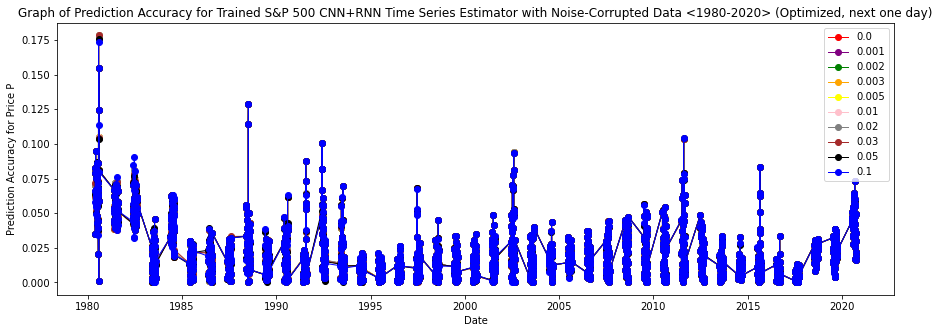

In [129]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):    
    plt.plot(date_test_partial, error_res_all_partial_1[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Data <1980-2020> (Optimized, next one day)')
plt.legend(loc="upper right") 

In [130]:
#predict next two day (idx = 1)
idx = 1
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [131]:
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_res_all_partial_2 = []
for i in range(len(sd)):
    temp = error_res_all[i].reshape(-1, 1)
    temp = temp[date_test > myDatetime,]
    error_res_all_partial_2.append(temp)

In [132]:
labels = date_test_partial + pd.Timedelta('1 day')
error_df=pd.DataFrame(error_res_all_partial_2, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1980-05-24,0.050426,0.050426,0.050425,0.050426,0.050425,0.050425,0.050425,0.050426,0.050426,0.050426
1980-05-28,0.053640,0.053640,0.053640,0.053640,0.053640,0.053640,0.053640,0.053640,0.053640,0.053640
1980-05-29,0.094593,0.094555,0.094736,0.094624,0.094439,0.095336,0.095442,0.095575,0.094983,0.090418
1980-05-30,0.088390,0.088389,0.088391,0.088390,0.088384,0.088393,0.088370,0.088372,0.088372,0.088265
1980-05-31,0.082083,0.082124,0.081907,0.082079,0.082416,0.081483,0.084889,0.077825,0.084251,0.075514
...,...,...,...,...,...,...,...,...,...,...
2020-09-22,0.032607,0.032607,0.032607,0.032607,0.032607,0.032607,0.032607,0.032607,0.032607,0.032607
2020-09-23,0.016119,0.016119,0.016119,0.016119,0.016119,0.016119,0.016120,0.016119,0.016118,0.016120
2020-09-24,0.024948,0.024948,0.024947,0.024948,0.024947,0.024952,0.024976,0.024899,0.024986,0.024877
2020-09-25,0.047333,0.047333,0.047333,0.047333,0.047333,0.047333,0.047333,0.047333,0.047333,0.047333


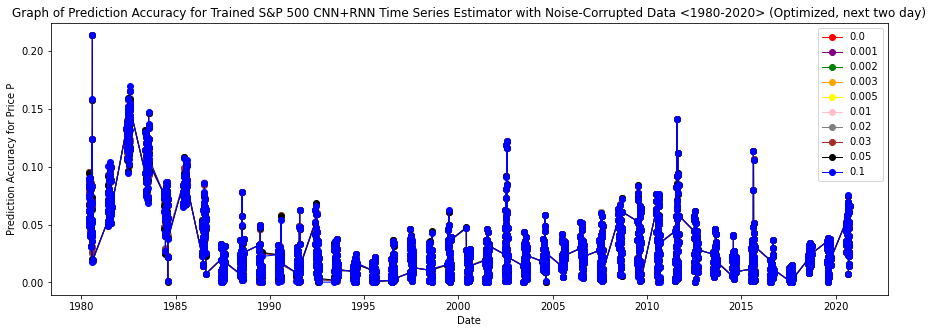

In [133]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):    
    plt.plot(date_test_partial+ pd.Timedelta('1 day'), error_res_all_partial_2[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Data <1980-2020> (Optimized, next two day)')
plt.legend(loc="upper right") 

In [134]:
#predict next three day (idx = 2)
idx = 2
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [135]:
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_res_all_partial_3 = []
for i in range(len(sd)):
    temp = error_res_all[i].reshape(-1, 1)
    temp = temp[date_test > myDatetime,]
    error_res_all_partial_3.append(temp)

In [136]:
labels = date_test_partial + pd.Timedelta('2 day')
error_df=pd.DataFrame(error_res_all_partial_3, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1980-05-25,0.015856,0.015856,0.015857,0.015856,0.015856,0.015856,0.015856,0.015857,0.015857,0.015856
1980-05-29,0.012980,0.012980,0.012980,0.012980,0.012980,0.012980,0.012980,0.012980,0.012980,0.012980
1980-05-30,0.032254,0.032267,0.032347,0.032228,0.032482,0.031465,0.033340,0.030180,0.029334,0.023462
1980-05-31,0.028806,0.028804,0.028807,0.028814,0.028818,0.028789,0.028736,0.028822,0.028612,0.028633
1980-06-01,0.021446,0.021491,0.021392,0.021289,0.021419,0.020418,0.020772,0.020765,0.026083,0.015946
...,...,...,...,...,...,...,...,...,...,...
2020-09-23,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000608,0.000607,0.000607,0.000608
2020-09-24,0.009961,0.009961,0.009961,0.009961,0.009961,0.009961,0.009961,0.009961,0.009961,0.009962
2020-09-25,0.031028,0.031028,0.031026,0.031025,0.031029,0.031025,0.031026,0.031012,0.031003,0.030995
2020-09-26,0.054680,0.054680,0.054680,0.054680,0.054680,0.054680,0.054680,0.054680,0.054680,0.054680


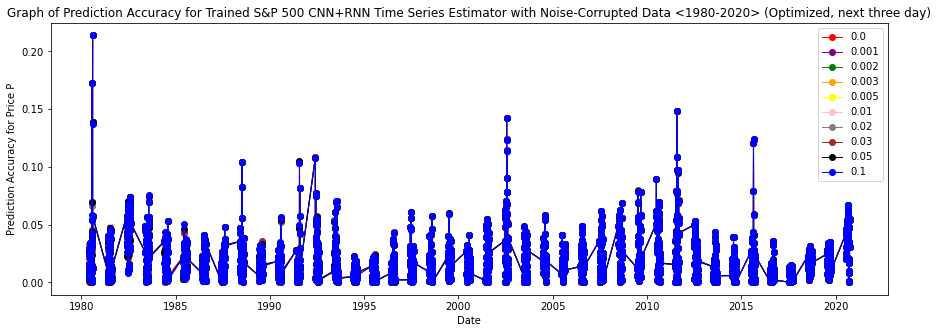

In [137]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):    
    plt.plot(date_test_partial+ pd.Timedelta('2 day'), error_res_all_partial_3[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Data <1980-2020> (Optimized, next three day)')
plt.legend(loc="upper right") 

In [138]:
#predict next four day (idx = 3)
idx = 3
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [139]:
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_res_all_partial_4 = []
for i in range(len(sd)):
    temp = error_res_all[i].reshape(-1, 1)
    temp = temp[date_test > myDatetime,]
    error_res_all_partial_4.append(temp)

In [140]:
labels = date_test_partial + pd.Timedelta('3 day')
error_df=pd.DataFrame(error_res_all_partial_4, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1980-05-26,0.095106,0.095107,0.095106,0.095107,0.095107,0.095107,0.095107,0.095106,0.095108,0.095106
1980-05-30,0.090386,0.090385,0.090386,0.090386,0.090385,0.090386,0.090386,0.090385,0.090386,0.090386
1980-05-31,0.073816,0.073922,0.073745,0.074047,0.073700,0.074564,0.074866,0.070400,0.076335,0.065031
1980-06-01,0.057467,0.057468,0.057461,0.057446,0.057474,0.057449,0.057317,0.057328,0.057441,0.057917
1980-06-02,0.085704,0.085677,0.085883,0.085769,0.085431,0.084483,0.087015,0.085912,0.087671,0.089733
...,...,...,...,...,...,...,...,...,...,...
2020-09-24,0.033008,0.033008,0.033008,0.033008,0.033008,0.033008,0.033008,0.033008,0.033008,0.033008
2020-09-25,0.059363,0.059363,0.059363,0.059363,0.059363,0.059363,0.059363,0.059363,0.059363,0.059363
2020-09-26,0.077220,0.077221,0.077222,0.077224,0.077223,0.077218,0.077212,0.077237,0.077253,0.077198
2020-09-27,0.078150,0.078150,0.078150,0.078150,0.078150,0.078150,0.078150,0.078150,0.078150,0.078150


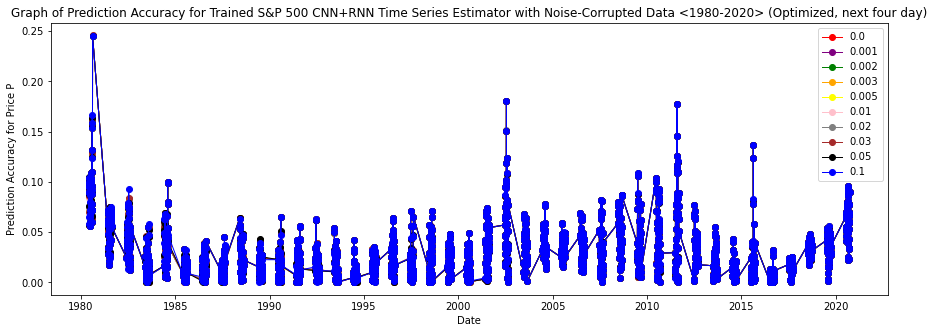

In [141]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):    
    plt.plot(date_test_partial + pd.Timedelta('3 day'), error_res_all_partial_4[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Data <1980-2020> (Optimized, next four day)')
plt.legend(loc="upper right") 

### 8c) Repeat Step 7, above, to Determine How Much Money You Make or Lose when the input is perturbed. 

In [142]:
X_full.shape

(14991, 180, 3)

In [143]:
X_train.shape

(11864, 180, 3)

In [144]:
X_test.shape

(3127, 180, 3)

In [145]:
# loading images of the test dataset
test_img = []
for i in range(X_test.shape[0]):  
    if i%500 == 0:
        print(i)
    x = X_test[i,:, 0]
    # function to plot the sp500 price data    
    plt.axis('off')
    plt.plot(x, color ="black") 
    figure = plt.gcf()
    figure.set_size_inches(8, 8)
    figure.canvas.draw()
       
    width, height = figure.get_size_inches() * figure.get_dpi()
    mplimage = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
    gray_image = color.rgb2gray(mplimage)
    img_resize = resize(gray_image, (180, 180),anti_aliasing=True)
    img_resize = img_resize.astype('float32')
    plt.clf()   
    # appending the image into the list
    test_img.append(img_resize)
    
# converting the list to numpy array
test_x = np.array(test_img)
# defining the target
test_x.shape

0
500
1000
1500
2000
2500
3000


(3127, 180, 180)

<Figure size 576x576 with 0 Axes>

In [146]:
# converting images into torch format
test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1], test_x.shape[2])
test_x = torch.from_numpy(test_x)
test_x.shape

torch.Size([3127, 1, 180, 180])

In [147]:
# predict sell signal for whole dataset
with torch.no_grad():
    output = model(test_x)

softmax = torch.exp(output)
# if prob > 0.5 then sell signal
# otherwise, hold 
prob = softmax.numpy()[:,1]/np.sum(softmax.numpy(), axis = 1) 

In [148]:
prob.shape

(3127,)

In [149]:
X_test.shape[0]

3127

In [150]:
money_res_all = []
trade_res_all = []
# sd = [0.001]
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    # loading images of the test dataset
    test_img = []
    for i in range(dataset_test_noise.shape[0]):  
        if i%500 == 0:
            print(i)
        x = dataset_test_noise[i,:, 0]
        # function to plot the sp500 price data    
        plt.axis('off')
        plt.plot(x, color ="black") 
        figure = plt.gcf()
        figure.set_size_inches(8, 8)
        figure.canvas.draw()

        width, height = figure.get_size_inches() * figure.get_dpi()
        mplimage = np.frombuffer(figure.canvas.tostring_rgb(), dtype='uint8').reshape(576, 576, 3)
        gray_image = color.rgb2gray(mplimage)
        img_resize = resize(gray_image, (180, 180),anti_aliasing=True)
        img_resize = img_resize.astype('float32')
        plt.clf()   
        # appending the image into the list
        test_img.append(img_resize)

    # converting the list to numpy array
    test_x = np.array(test_img)
    
    # converting images into torch format
    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1], test_x.shape[2])
    test_x = torch.from_numpy(test_x)
    
    
    # predict sell signal for whole dataset
    with torch.no_grad():
        output = model(test_x)

    softmax = torch.exp(output)
    # if prob > 0.5 then sell signal
    # otherwise, hold 
    prob = softmax.numpy()[:,1]/np.sum(softmax.numpy(), axis = 1) 
    
    # assuming you start with $1 million.
    money = 1
    money_full = []
    trade_full = []
    # if you haven't sell the stock, you cannot buy the new stock, in that case buypower = 0
    lastselltime = 0
    for i in range(1, X_test.shape[0]):
        temp = sc.inverse_transform(X_test[i,:, :])
        prob_temp = prob[i]
        price_temp = temp[:, 0]
        date_diff = date_test[i,0] - date_test[lastselltime,0]
        days = date_diff.astype('timedelta64[D]')
        days_diff = days / np.timedelta64(1, 'D')
        if prob_temp > 0.95 and (days_diff > nsample):
            # sell at this point
            # buy at the local minia in this window interval
            buy_price = min(price_temp)
            # in case of the overflow
            if buy_price > 0:              
                sell_price = price_temp[len(price_temp)-1]
                money = sell_price/buy_price*money
                lastselltime = i
                print(money)
                print(i)   
                money_full.append(money)
                trade_full.append(i)
                
            
    money_res_all.append(money_full)
    trade_res_all.append(trade_full)
    
    
    

0.0
0
500
1000
1500
2000
2500
3000
1.2413535149989336
53
1.4468440801468916
106
1.5646270450295847
168
1.9192331925619268
267
2.387246462745722
477
2.829427108235868
530
4.09194771565113
689
5.043528932192679
742
5.5408473867455745
941
7.61693968113156
1113
8.83860879681005
1219
11.974147586733421
1272
15.037604422241488
1325
18.330464734093848
1432
23.695720911594822
1537
27.85557134438574
1749
32.48053064966163
1802
41.23880585616208
1855
51.293759568545504
1908
69.19396862668401
1961
79.71245807375031
2385
117.59452153773782
2541
139.57403445991554
2703
162.19935319154834
2756
192.43681434756894
2879
222.39068731431064
2915
285.62035803955587
3030
0.001
0
500
1000
1500
2000
2500
3000
1.2413535149989336
53
1.4468440801468916
106
1.5646270450295847
168
1.9192331925619268
267
2.387246462745722
477
2.829427108235868
530
4.09194771565113
689
5.043528932192679
742
5.545209829329371
940
7.622936681175753
1113
8.845567646369588
1219
11.983575121493175
1272
15.049443890342847
1325
18.3448967

<Figure size 576x576 with 0 Axes>

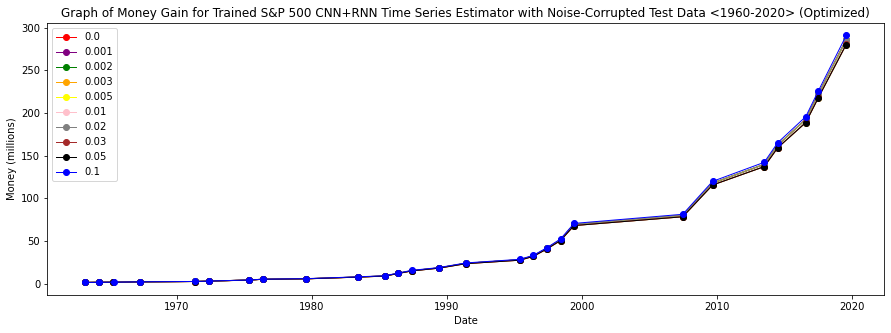

In [151]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(sd)):   
    plt.plot(date_test[trade_res_all[i]], money_res_all[i] , color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
plt.xlabel('Date')
plt.ylabel('Money (millions)')
plt.title('Graph of Money Gain for Trained S&P 500 CNN+RNN Time Series Estimator with Noise-Corrupted Test Data <1960-2020> (Optimized)')
plt.legend(loc="upper left") 

In [152]:
money_res_all[1]

[1.2413535149989336,
 1.4468440801468916,
 1.5646270450295847,
 1.9192331925619268,
 2.387246462745722,
 2.829427108235868,
 4.09194771565113,
 5.043528932192679,
 5.545209829329371,
 7.622936681175753,
 8.845567646369588,
 11.983575121493175,
 15.049443890342847,
 18.344896750418297,
 23.714377123315394,
 27.877502706530713,
 32.50610335364719,
 41.271274161136915,
 51.33414438072426,
 69.248446704532,
 79.77521761164914,
 117.68710653648812,
 139.68392445850614,
 162.3270566484455,
 192.58832448582112,
 222.56578085810696,
 285.84523382582853]

In [153]:
money_res_all[7]

[1.2413535149989336,
 1.4468440801468916,
 1.5358039965356576,
 1.883877705414943,
 2.3432693879653392,
 2.7721063798251455,
 4.009049865765907,
 4.9413532121282415,
 5.439816023990675,
 7.478053019526793,
 8.67744631943605,
 11.755811948865126,
 14.763409960401146,
 17.996228523862495,
 23.263655054504987,
 27.347655111216827,
 31.888283282880245,
 40.48686080818993,
 50.358473308463886,
 67.93229140354005,
 78.25898756543083,
 115.45031255051894,
 137.02905281317015,
 159.24182331442054,
 188.92793705124515,
 218.33563352287956,
 280.4123795501451]

In [154]:
money_res_all[5]

[1.2413535149989336,
 1.4468440801468916,
 1.5336689051663774,
 1.8844015034317805,
 2.343920916381862,
 2.7780765345627834,
 4.0176839673370885,
 4.951995171435587,
 5.444571185893446,
 7.484589886337827,
 8.685031624153995,
 11.766088176750197,
 14.776315250633221,
 18.011959750781354,
 23.283990750739296,
 27.371560796104237,
 31.91615811341547,
 40.52225200105911,
 50.40249367472297,
 67.99167375077853,
 78.32739689298519,
 115.55123231057742,
 137.1488354176988,
 159.38102299474306,
 188.78984888575155,
 218.17605115742518,
 280.2074250490897]